<a href="https://colab.research.google.com/github/idan424/Comp.Learning_Neuro/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.simplefilter("ignore")
 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
 
from sklearn.model_selection import train_test_split


In [ ]:
!git clone https://github.com/idan424/Comp.Learning_Neuro

fatal: destination path 'Comp.Learning_Neuro' already exists and is not an empty directory.


In [ ]:
PATH = '/content/Comp.Learning_Neuro/'
_files = ['Run_200 02.trc', 'Run_300 02.trc', 
          'Run_400 02.trc', 'Run_500 02.trc']
f = _files[0]

In [ ]:
def load_data(f):
    _data = pd.read_table(PATH+f, header=4, index_col=0).iloc[:,:-1]
    _data = _data.rename(columns={'Unnamed: 1':'Time'})
    _data.reset_index(inplace=True)
    labels = pd.DataFrame(np.ones(len(_data)-2)*int(f[4:7]))
    
    return _data, labels
    
 
def add_norm(_data):
    for n in range(1,len(_data.columns)//3+1):
        R_data = np.linalg.norm(_data[[f"X{n}",f"Y{n}",f"Z{n}"]].values,axis=1)
        _data.insert(n*4+1,f'norm{n}',R_data)
    
    return _data
    
 
def add_av(_data):
    v_data = _data.copy().drop(['Time','index'], axis=1).diff()
    a_data = v_data.diff()
 
    v_data = v_data.rename(columns={n:f"V_{n}" for n in _data.columns})
    a_data = a_data.rename(columns={n:f"A_{n}" for n in _data.columns})
 
    return _data.join([v_data, a_data]).dropna()
 
 
def divide_dataset(_data, label):
    N = len(_data)//10
    
    return [ _data.loc[10*n:10*(n+1)-1] for n in range(N)], label[0:N]
 
 
def segment_processing(_seg): 
    seg = _seg.drop(['Time','index'], axis=1)
 
    mean_data = seg.mean().rename({n:f'mean_{n}'for n in seg.columns})
    std_data = seg.std().rename({n:f'std_{n}'for n in seg.columns})
    max_data = seg.max().rename({n:f'max_{n}'for n in seg.columns})
    min_data = seg.min().rename({n:f'min_{n}'for n in seg.columns})
    median_data = seg.median().rename({n:f'median_{n}'for n in seg.columns})
 
    return mean_data.append([std_data,max_data,min_data,median_data])  # returns a pd.Series()
 
 
def extract_features(seg_list):
    data = pd.DataFrame([segment_processing(seg) for seg in seg_list]) 
    
    return data
 
 
def process_file(f):
    X,y = load_data(f)
    X = add_norm(X)
    X = add_av(X)
    
    segments, y = divide_dataset(X, y)
    X = extract_features(segments)
 
    return (X,y)  # returns a tuple

In [ ]:
files = _files
Xy = [process_file(f) for f in files]
Xy = list(zip(*Xy))  # this flip the tuple axis order
 
X, y = pd.concat(Xy[0]), pd.concat(Xy[1])
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

In [ ]:
print(X.shape,y.shape)

(190, 2520) (190, 1)


> # Train Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)

In order to avoid leakage, we fit our transforms (norm, feat. select.) on the training data, and then transform the data (both train and test)

In [ ]:
from sklearn.feature_selection import mutual_info_classif as MI
from sklearn.feature_selection import SelectKBest as SKB 
from sklearn.preprocessing import MinMaxScaler as NRM
 
NUMBER_OF_FEATURES = int(X_train.shape[0]**0.5)
 
nrm = NRM().fit(X_train.values) # normalization function
skb = SKB(score_func=MI, k=NUMBER_OF_FEATURES).fit(X_train, y_train) # feature selector utility
 
# X_train and X_test are both normalized with respect to X_train to prevent leakage
X_train = pd.DataFrame(nrm.transform(X_train.values), columns=X_train.columns)
X_test = pd.DataFrame(nrm.transform(X_test.values), columns=X_test.columns)
 
# These are the best-K feature matrices (np.array type)
X_train_skb = skb.transform(X_train)  
X_test_skb = skb.transform(X_test)

# features and scores

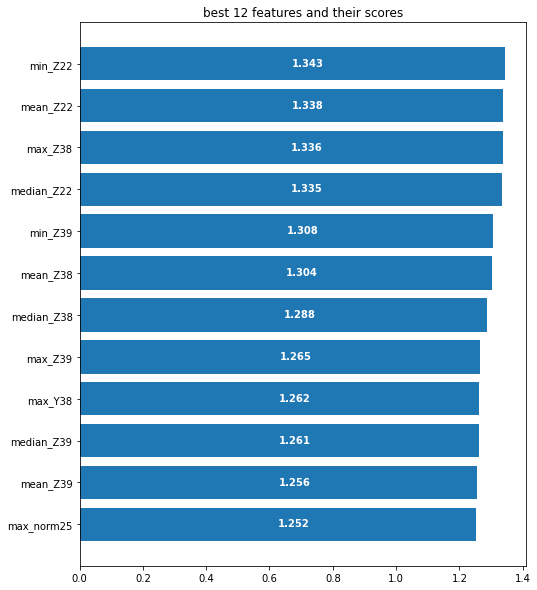

In [ ]:
N_PRINT = NUMBER_OF_FEATURES
# this gets $N_PRINT score indices from high to low
ord_idx = skb.scores_.argsort()[-N_PRINT-1:-1]
 
fig, ax = plt.subplots()  
fig.set_size_inches([8,N_PRINT/3+6]) # modular figure size w.r.t. $N_PRINT
 
# these just prettify the graph
_ = ax.barh(range(N_PRINT), skb.scores_[ord_idx], 
            tick_label=X_train.columns[ord_idx])
_ = ax.set_title(f"best {N_PRINT} features and their scores")
for i, v in enumerate(skb.scores_[ord_idx]):
    ax.text(v/2, i-0.05, f'{v:.4}', color='white', fontweight='bold')


In [ ]:
cols = X.columns[ord_idx]
correlation_matrix = np.corrcoef(np.transpose(X[cols]))

def print_mat(mat):
    s = [[f"{n:.3f}" for n in row] for row in mat]
    lens = [max(map(len, col)) for col in zip(*s)]
    fmt = '\t'.join('{{:{}}}'.format(x) for x in lens)
    table = [fmt.format(*row) for row in s]
    print('\n'.join(table))

print_mat(correlation_matrix)

1.000 	-0.712	-0.712	0.775 	-0.716	0.416 	0.417 	-0.707	-0.740	0.435 	-0.740	-0.738
-0.712	1.000 	1.000 	-0.827	1.000 	-0.667	-0.668	1.000 	0.890 	-0.664	0.891 	0.886 
-0.712	1.000 	1.000 	-0.827	0.999 	-0.667	-0.668	0.999 	0.890 	-0.664	0.890 	0.886 
0.775 	-0.827	-0.827	1.000 	-0.831	0.179 	0.180 	-0.823	-0.582	0.182 	-0.583	-0.577
-0.716	1.000 	0.999 	-0.831	1.000 	-0.663	-0.664	0.998 	0.887 	-0.660	0.888 	0.883 
0.416 	-0.667	-0.667	0.179 	-0.663	1.000 	1.000 	-0.671	-0.878	0.998 	-0.878	-0.879
0.417 	-0.668	-0.668	0.180 	-0.664	1.000 	1.000 	-0.672	-0.879	0.998 	-0.879	-0.880
-0.707	1.000 	0.999 	-0.823	0.998 	-0.671	-0.672	1.000 	0.893 	-0.668	0.893 	0.889 
-0.740	0.890 	0.890 	-0.582	0.887 	-0.878	-0.879	0.893 	1.000 	-0.884	1.000 	1.000 
0.435 	-0.664	-0.664	0.182 	-0.660	0.998 	0.998 	-0.668	-0.884	1.000 	-0.884	-0.886
-0.740	0.891 	0.890 	-0.583	0.888 	-0.878	-0.879	0.893 	1.000 	-0.884	1.000 	1.000 
-0.738	0.886 	0.886 	-0.577	0.883 	-0.879	-0.880	0.889 	1.000 	-0.886	1.000 

In [ ]:
# plt.plot(X_train_skb)

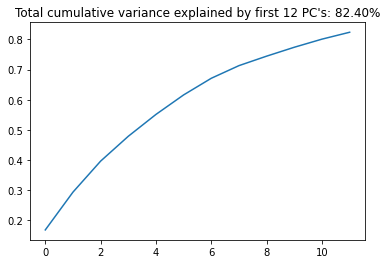

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=NUMBER_OF_FEATURES)
pca.fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


evr = pca.explained_variance_ratio_
cumulative_evr = np.cumsum(evr)

_ = plt.plot(cumulative_evr)
_ = plt.title(f"Total cumulative variance explained by first {NUMBER_OF_FEATURES} PC's: {cumulative_evr[-1]*100:.2f}%")

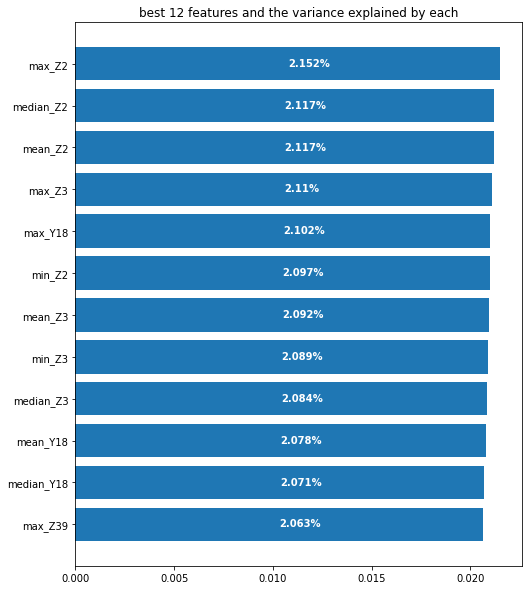

In [ ]:
# for every original feature we calculate the weighted (by var explained PC) sum of variance which is explained by it
var_per_orig_feature = evr.dot(pca.components_)
# then we take the 12 most "succesfull" features
pca_best_idx = var_per_orig_feature.argsort()[-NUMBER_OF_FEATURES:][::-1]
pca_best_scores = var_per_orig_feature[pca_best_idx][::-1]
pca_best_names = X.columns[pca_best_idx][::-1]


fig, ax = plt.subplots()  
fig.set_size_inches([8,N_PRINT/3+6]) # modular figure size w.r.t. $N_PRINT
 
# these just prettify the grap
_ = ax.barh(range(N_PRINT), pca_best_scores, 
            tick_label=pca_best_names)
_ = ax.set_title(f"best {N_PRINT} features and the variance explained by each")
for i, v in enumerate(pca_best_scores):
    ax.text(v/2, i-0.05, f'{v*100:.4}%', color='white', fontweight='bold')



## _##########################################################_

## Models

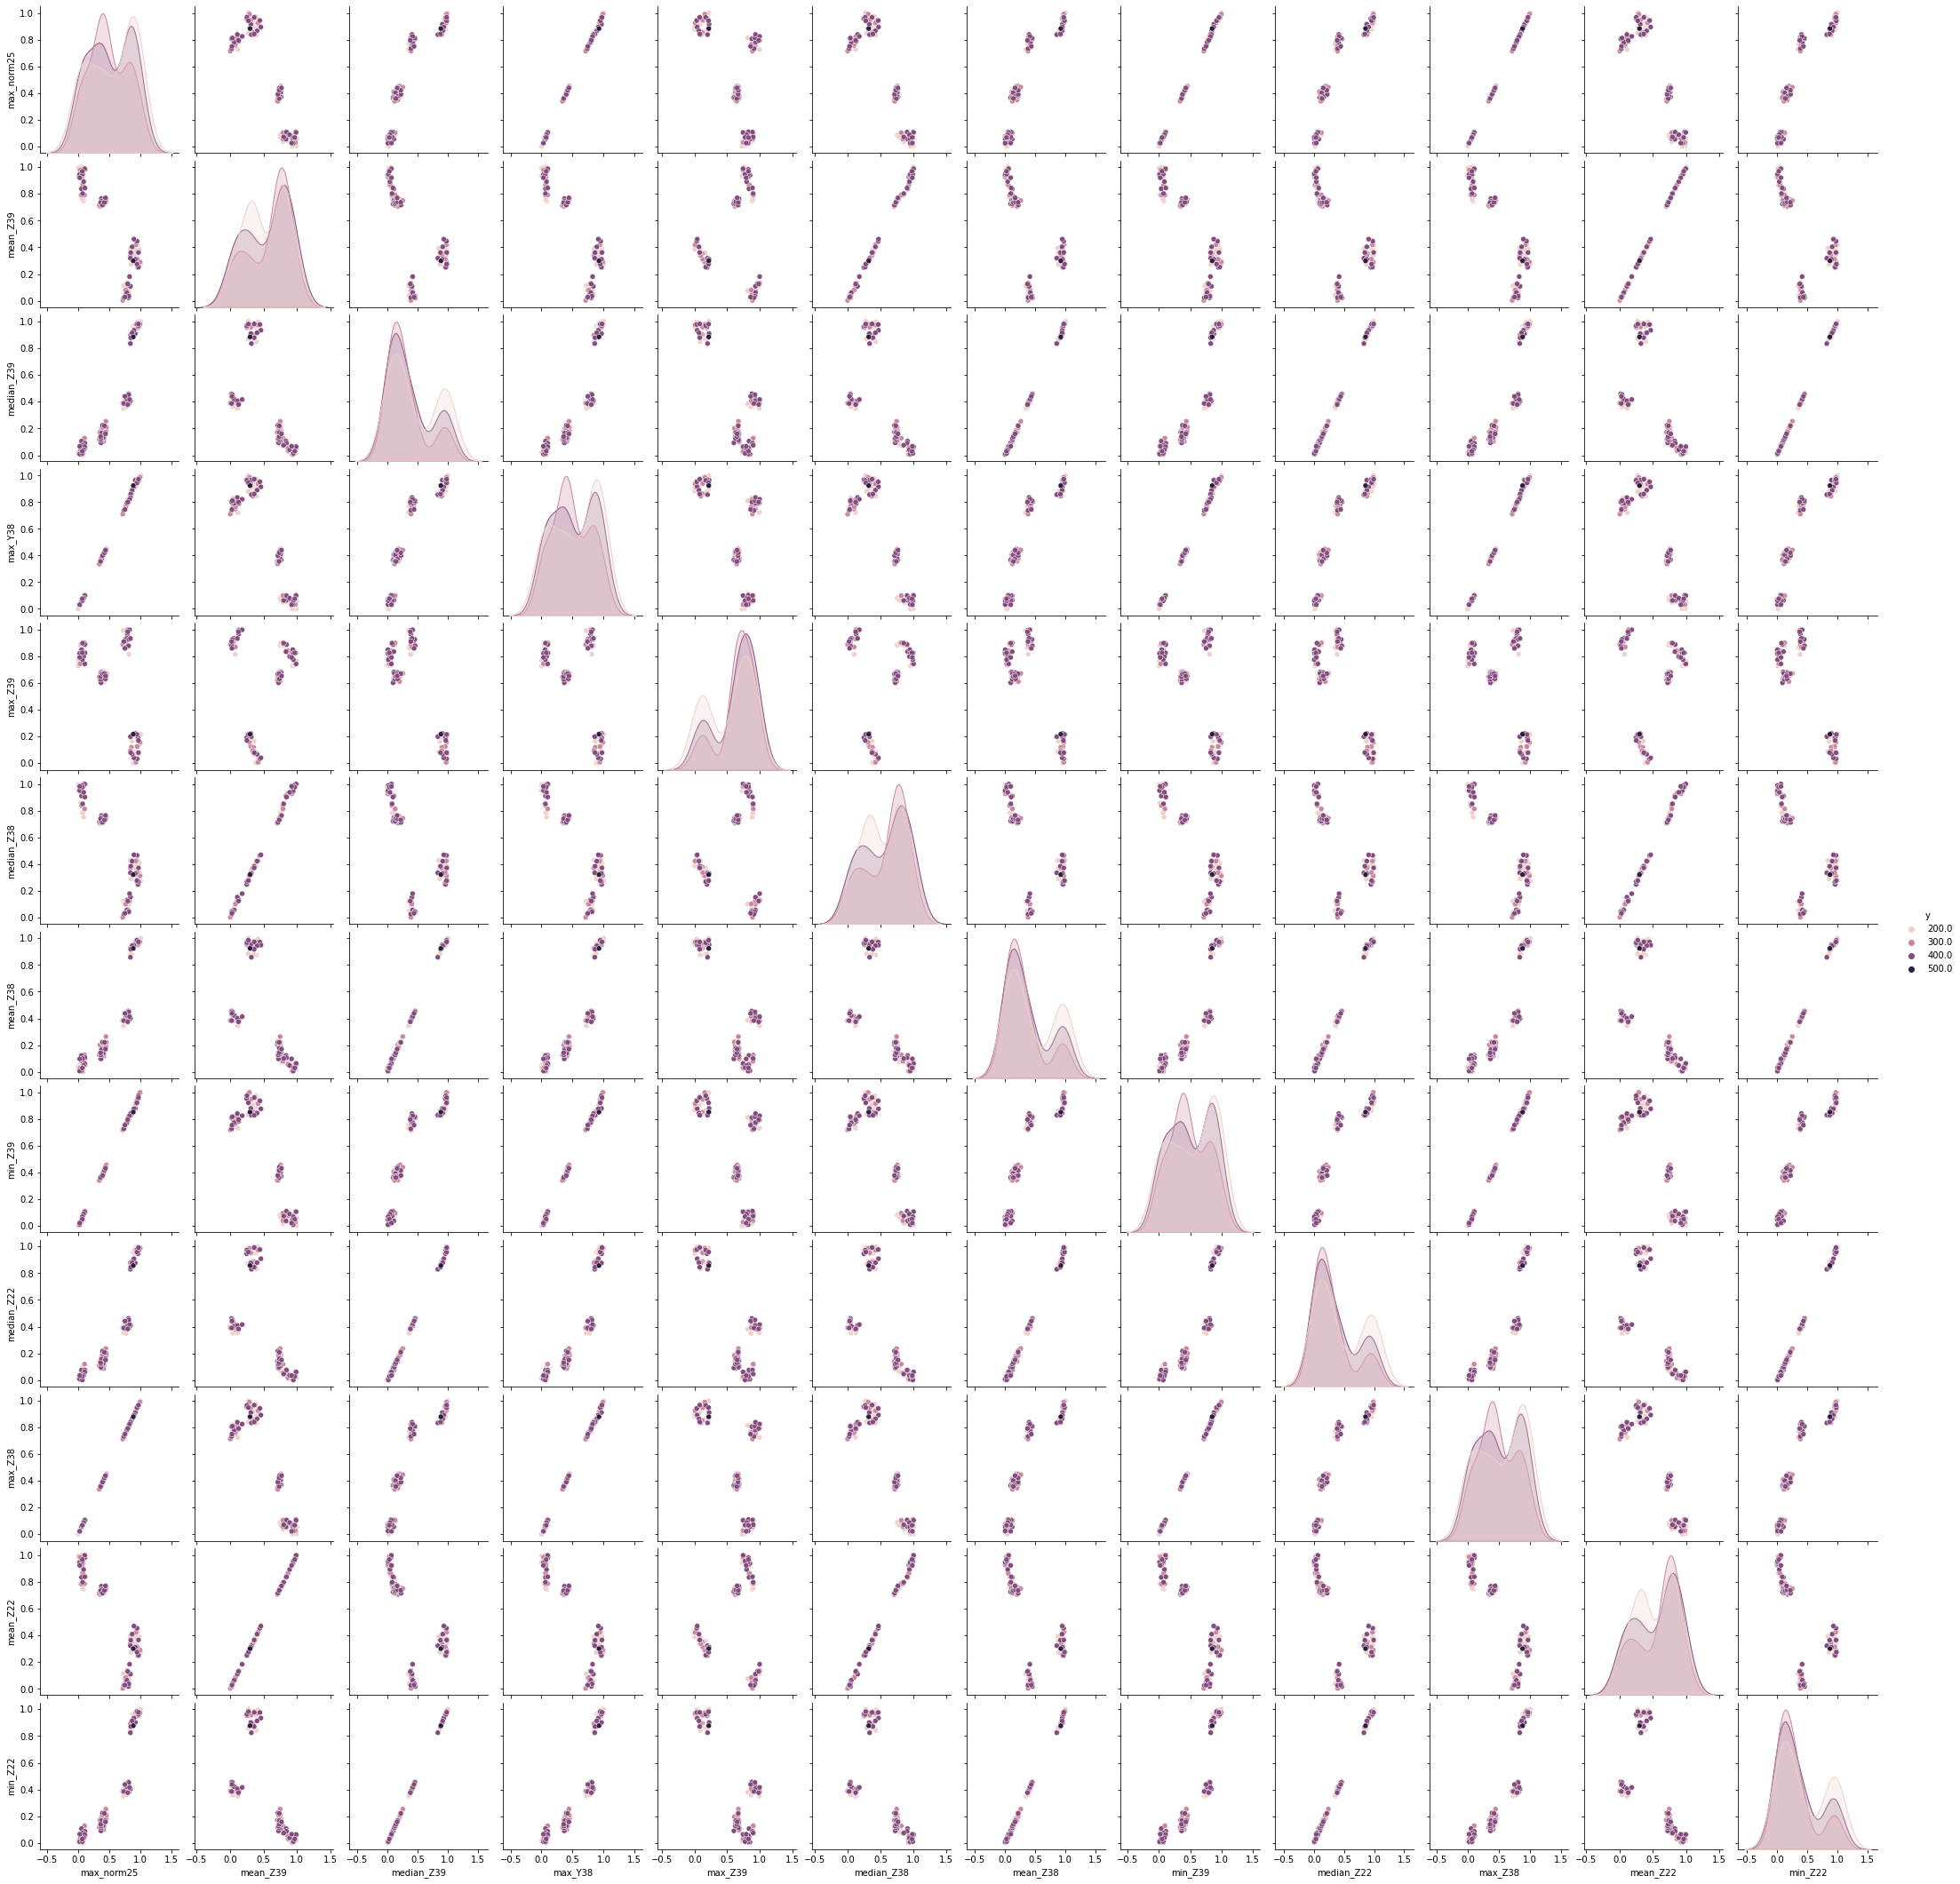

In [ ]:
# this takes a few minutes to calculate - avoid if possible
X_skb = pd.DataFrame(data=X_train_skb, columns=X_train.columns[ord_idx])
X_skb['y'] = y_train
_ = sns.pairplot(X_skb, hue='y')

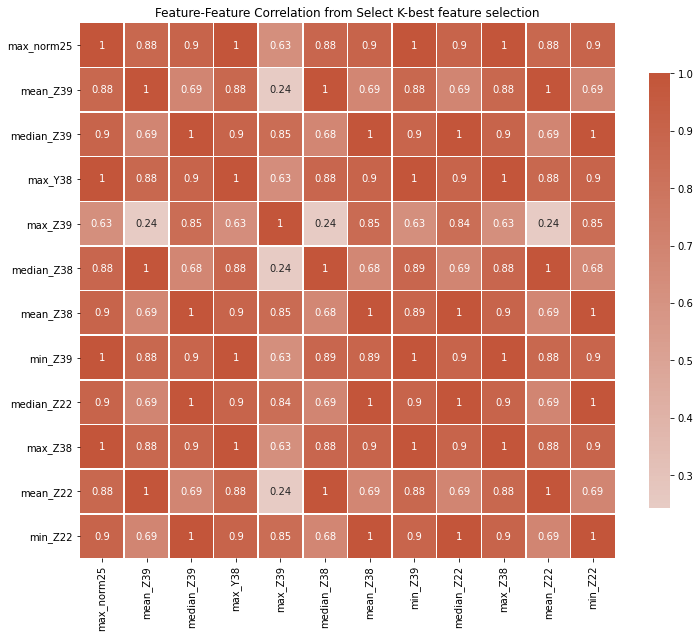

In [ ]:
corr = pd.DataFrame(data=X_train_skb, columns=X_train.columns[ord_idx]).corr()

# cmap = sns.diverging_palette(230, 20, as_cmap=True)

plt.figure(figsize=(12,16))
_ = sns.heatmap(corr, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5, 
                cbar_kws={"shrink": .5}, annot=True)

_ = plt.title("Feature-Feature Correlation from Select K-best feature selection")

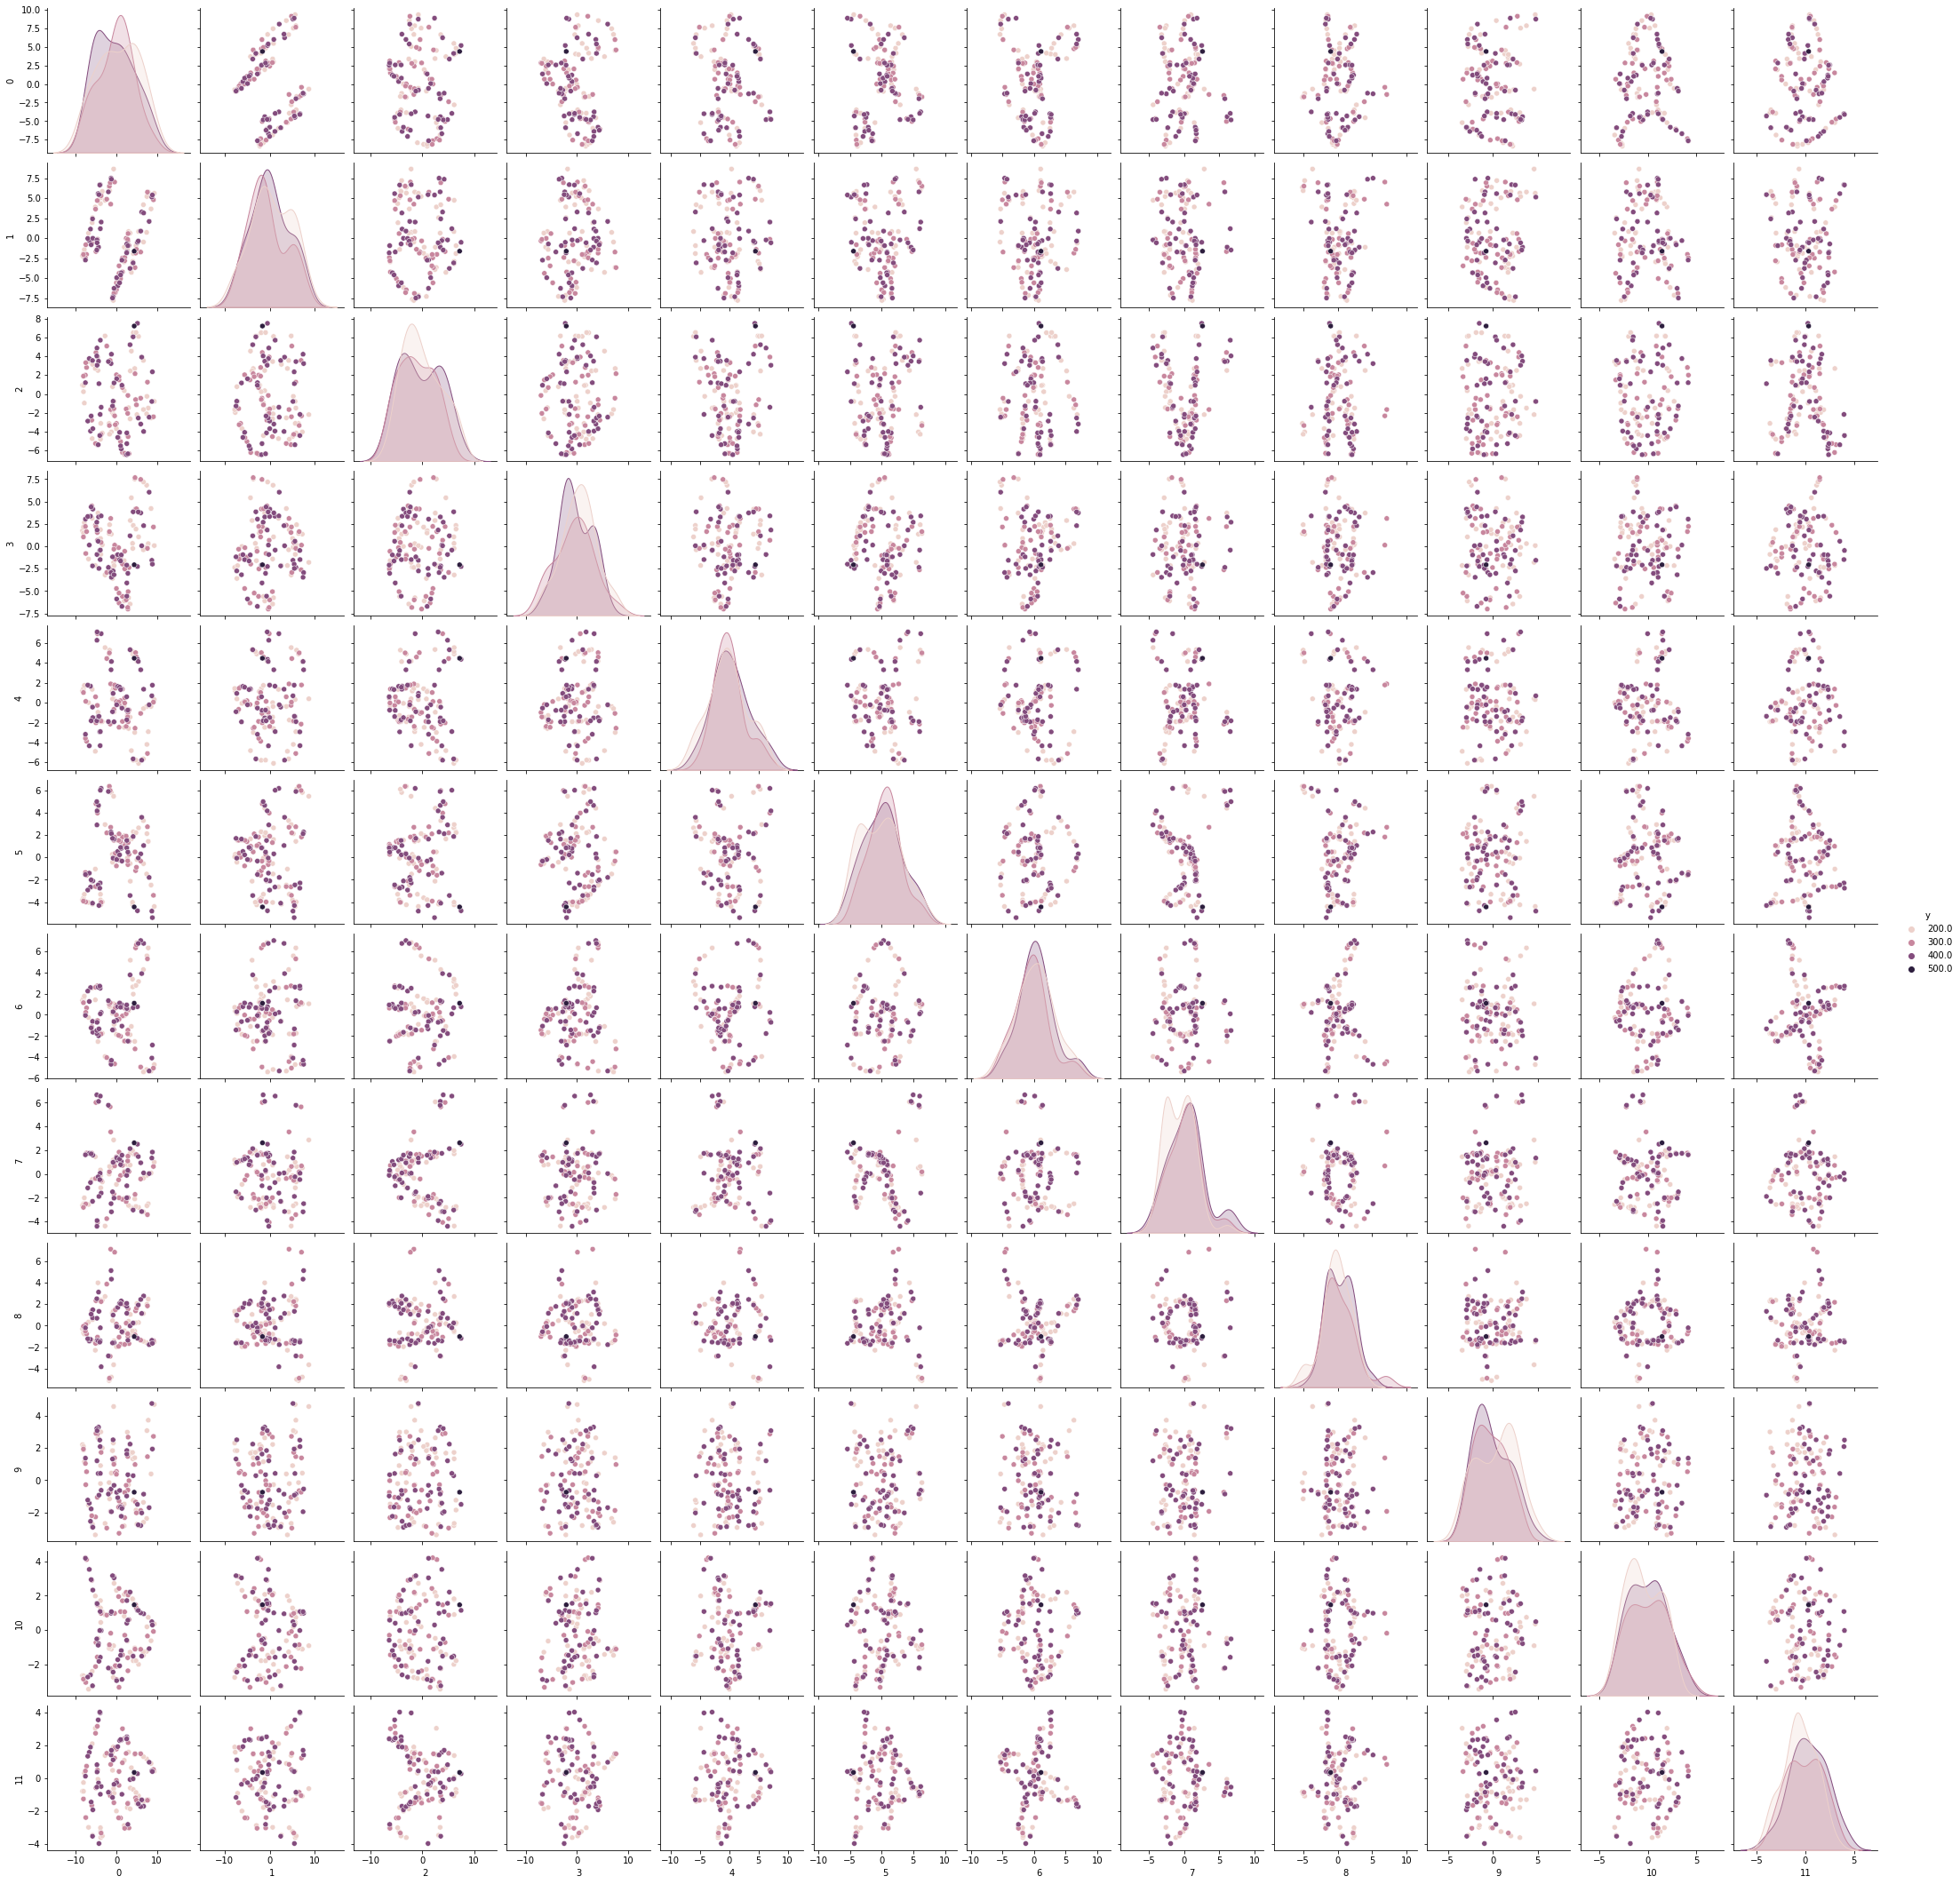

In [ ]:
# this takes a few minutes to calculate - avoid if possible
X_pca = pd.DataFrame(data=X_train_pca)
X_pca['y'] = y_train
_ = sns.pairplot(X_pca, hue='y')

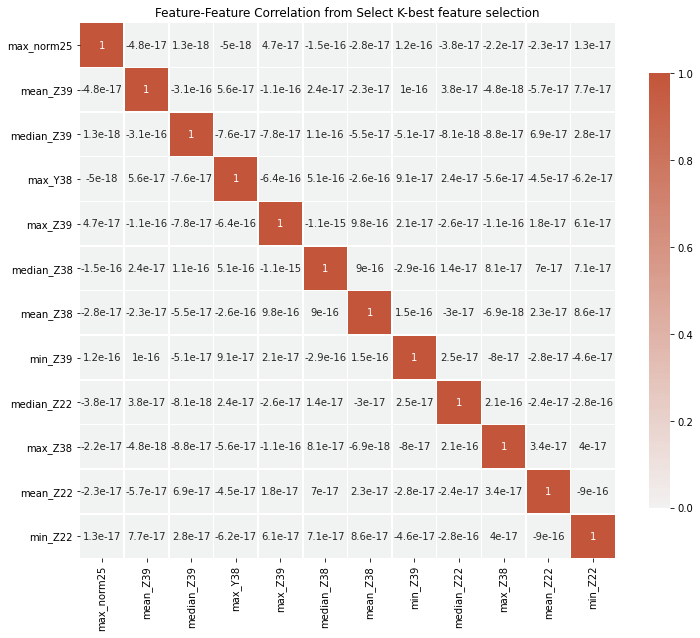

In [ ]:
corr = pd.DataFrame(data=X_train_pca).corr()

plt.figure(figsize=(12,16))
_ = sns.heatmap(corr, cmap=cmap, vmax=1, center=0, square=True, 
                linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

_ = plt.title("Feature-Feature Correlation from PCA feature extraction")

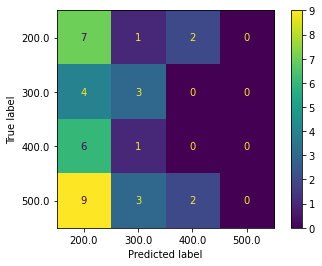

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

knn_skb = KNeighborsClassifier(n_neighbors=12)
_ = knn_skb.fit(X_train_skb, y_train)

y_pred_skb = knn_skb.predict(X_test_skb)
y_pred_skb = pd.DataFrame(data=y_pred_skb, index = y_test.index)
 
plot_confusion_matrix(knn_skb, X_test_skb, y_test)

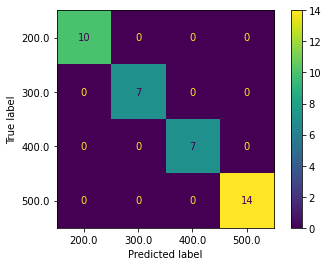

In [ ]:
knn_pca = KNeighborsClassifier(n_neighbors=12)
_ = knn_pca.fit(X_train_pca, y_train)

y_pred_pca = knn_pca.predict(X_test_pca)
y_pred_pca = pd.DataFrame(data=y_pred_pca, index = y_test.index)
 
plot_confusion_matrix(knn_pca, X_test_pca, y_test)